In [ ]:
to develop a machine learning model using Python which can predict the number of calories a person has burnt 
during a workout !! based on some biological measures !!.

In [183]:
import pandas as pd

data = pd.read_csv('playground-series-s5e5/train.csv')
data.head(5)
# data = data.drop(['id'], axis=1)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [62]:
data.shape

(750000, 8)


Data EDA


In [180]:

data.isnull().sum()
data.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


Here we will check the data for "adequacy". Why? I just want to be sure that this set is representative and sufficient to solve
the problem was asked.

#For example it's useful to check the balance of key categories (Sex) and ranges of numerical features (Age, Height, Weight).


In [71]:

def fast_representative_checking(df):
    # key groups
    #categorical_colms 
    col = 'Sex'
    counts = data[col].value_counts() 
    print(counts)
    diff = abs(counts.iloc[0] - counts.iloc[1])
    percent_diff = diff / counts.sum() * 100
    print(f"Difference between categories: {diff} rows ({percent_diff:.2f}%)")
    
    if percent_diff < 5:
        print("The balance for the ", col, "category is good - the categories are distributed almost evenly.")
    else:
        print("There is an imbalance ", col)

    print("Age from 20 to 79 - ok")
    print("Height from 126 to 222 - ok")
    print("Weight from 36 to 132 - ok")
        
fast_representative_checking(data)

Sex
female    375721
male      374279
Name: count, dtype: int64
Difference between categories: 1442 rows (0.19%)
The balance for the  Sex category is good - the categories are distributed almost evenly.
Age from 20 to 79 - ok
Height from 126 to 222 - ok
Weight from 36 to 132 - ok


Now let's look for something interesting in the data. Let's think logically about which signs have a greater impact on burning calories.


Let's consider a special case simply by the first row in the data (male, Age==36, Height==189.0, Weight==82.0), we will make such a filter

In [181]:

# for both 'Sex' male and female works.
numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()
print(correlation_matrix['Calories'])
a = data[(data.Sex == 'male') & (data.Age==36) & (data.Height == 189.0) & (data.Weight == 82.0)]
a

# maybe here we can check the "adequacy" of the data as well, like they gave some normal for the same person. 
# like with a lower Duration, Heart_Rate, Body_Temp, then Calories will be lower.
# by the way, from this part of data I see that these are the most defining features [Duration Heart_Rate Body_Temp].
# can even confirm .corr()


id            0.001148
Age           0.145683
Height       -0.004026
Weight        0.015863
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Calories      1.000000
Name: Calories, dtype: float64


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
385674,385674,male,36,189.0,82.0,20.0,105.0,40.6,125.0
589300,589300,male,36,189.0,82.0,16.0,98.0,40.0,79.0
630981,630981,male,36,189.0,82.0,9.0,94.0,39.6,42.0
642830,642830,male,36,189.0,82.0,30.0,108.0,40.8,192.0


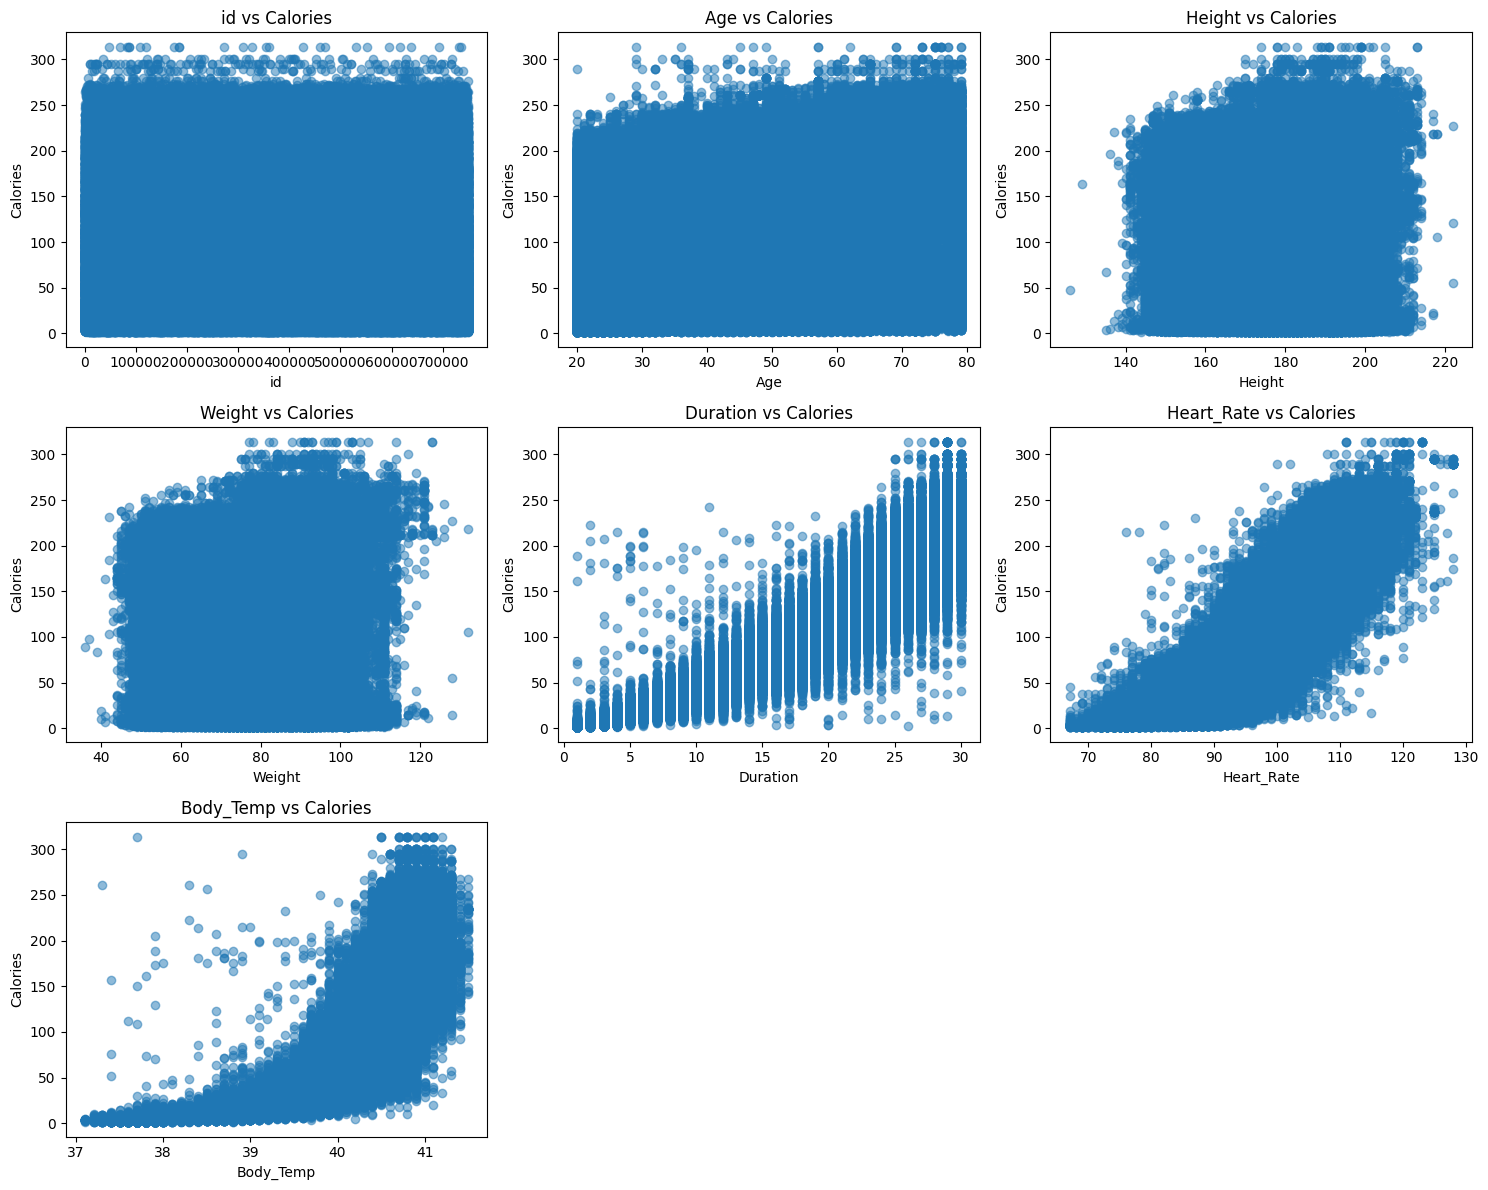

In [73]:
# since we saw the first idea the most defining features [Duration Heart_Rate Body_Temp], let's visualize this relatioship features and target
# using scatterplot. 

import pandas as pd
import matplotlib.pyplot as plt

def scatter_plots_for_all_features(data):

    # Select only numeric features to avoid plotting strings/categories
    features = data.select_dtypes(include='number').drop(columns='Calories').columns
    
    # Subplot layout settings
    n_cols = 3
    n_rows = -(-len(features) // n_cols)  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Flatten 2D array of axes to 1D for easy indexing
    
    # Plot each feature
    for i, feature in enumerate(features):
        axes[i].scatter(data[feature], data['Calories'], alpha=0.5)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Calories')
        axes[i].set_title(f'{feature} vs Calories')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# data = pd.read_csv('playground-series-s5e5/train.csv')
scatter_plots_for_all_features(data)


Let's analyze the information received:
- Age vs Calories , Height vs Calories, Weight vs Calroies - no obvious relationship.
- Duration vs Calories, Heart_Rate vs Calories, Body_tem vs Calories - the high correlation that we noticed earlier was confirmed.

Else I see some non-linear pattern in those high-correlated data. To analyse it I will try to fit it by some polynomial function or something else, but for the simple baseline let's check linear function to high-correlated features. 

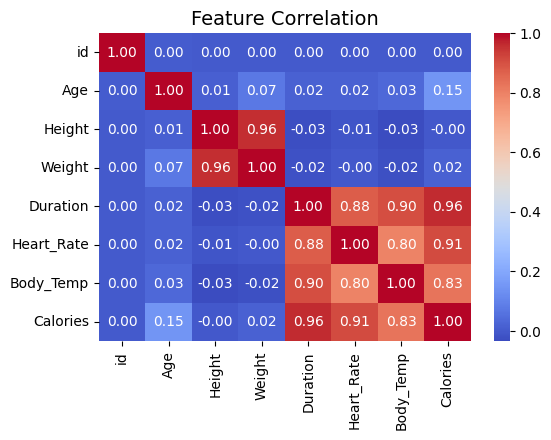

In [184]:
# Let's check by visualaize correlation features with each other as well.
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation", fontsize=14)
plt.show()

# What we see here?:
# the [Duration Heart_Rate Body_Temp] are highly correlated with each other - almost all correlations > 0.8. multicollinearity.
# So possibly these features are about the same information. 

# So to predict Calories we can try to train a model on one feature (for example, Duration) and 
# compare the quality (R², MAE, RMSE) with a model on three features.


Ready for our 1st hypothesys: simple baseline, let's check the linear function for  highly correlated features.


Data Prep & Modeling

In [185]:
data = pd.get_dummies(data, columns=['Sex'], drop_first=True) # why? it's simple and enough. 
data = data.drop('id', axis=1)

In [186]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [157]:
data.shape

(750000, 8)

In [196]:
# Linear approximation 'By High Correlated features' : For every person, predict their Calories by [Duration,Heart_Rate, Body_Temp].

#X = data[['Duration']]
#X = data[['Duration','Heart_Rate','Body_Temp']] 
#target = 'Calories'
X = data.drop(columns=[target])  
y = data[target] 

X = X.to_numpy()
y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#model = LinearRegression() # y = w0 + w1 * 'Duration' + w2 * 'Heart_Rate' + w3 * 'Body_Temp'
poly = PolynomialFeatures(degree=2)
model = make_pipeline(poly, LinearRegression())
#model = GradientBoostingRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Visualization Model with 1 feature
'''
order = np.argsort(X_test[:, 0])
plt.scatter(X_train[:, 0], y_train, color='blue', alpha=0.5, label='Data')
plt.plot(X_test[:, 0][order], y_pred[order], color='red', label='Linear Model')
plt.xlabel("Heart_Rate")
plt.ylabel('Calories')
plt.legend()
plt.grid()
plt.show()
'''

print("MSE:", mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("RMSE:", rmse)

MSE: 19.35027841813216
RMSE: 4.398895136069075


In [158]:
len(feature_names)

36

In [197]:
# get the linear regression model itself
lin_reg = model.named_steps['linearregression']

# Features names of this polynomial fit
feature_names = poly.get_feature_names_out()

print("Intercept:", lin_reg.intercept_)
print("Coefficients:")
for name, coef in zip(feature_names, lin_reg.coef_):
    print(f"{name}: {coef}")

Intercept: -642.7434603536127
Coefficients:
1: 1.6378584123069046e-11
x0: -1.112709542361724
x1: -0.31007237026487655
x2: -0.5098749727353951
x3: -13.457260476869003
x4: -0.348259508451566
x5: 35.72628025163556
x6: 61.336269888819835
x0^2: -0.00024348579389222056
x0 x1: 6.685877940436997e-05
x0 x2: 0.001584851490491644
x0 x3: 0.03088411294098159
x0 x4: 9.10377378743436e-05
x0 x5: 0.020653063388496932
x0 x6: 0.4187243150171782
x1^2: 0.0006234461275618286
x1 x2: 0.0002590804000242561
x1 x3: -0.007651066091855894
x1 x4: -0.0018438269407385322
x1 x5: 0.008350003372242223
x1 x6: 0.07426486135448497
x2^2: 0.0012706651260490376
x2 x3: 0.014727465672802536
x2 x4: 0.003935329319689339
x2 x5: -0.01237739349269911
x2 x6: 0.29571969509502194
x3^2: 0.0014340346850497574
x3 x4: 0.11788610526265053
x3 x5: 0.15229787215890625
x3 x6: 0.2654300638867832
x4^2: 0.0026838261486523164
x4 x5: -0.006734512291258314
x4 x6: 0.5473785267923663
x5^2: -0.438254689564377
x5 x6: -5.775953307106306
x6^2: 61.336269888

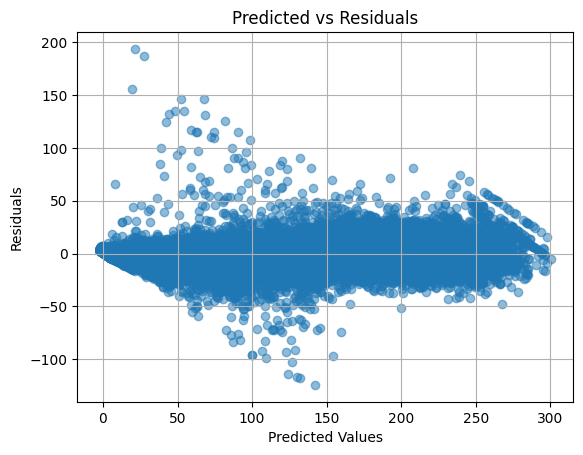

In [192]:
import matplotlib.pyplot as plt

# Important!: residuals analysis is done on Train_set, not a Test_set. Because it's analysis the model itself, 
# not about its generalization ability
y_pred = model.predict(X_train)
residuals = y_train - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
#plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Predicted vs Residuals")
plt.grid(True)
plt.show()



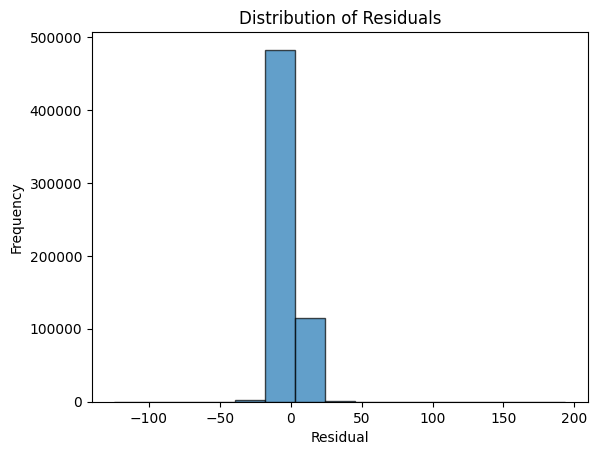

In [193]:
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

The exponential model was build : y = 100.77 * exp(0.0382 * x) + -102.62


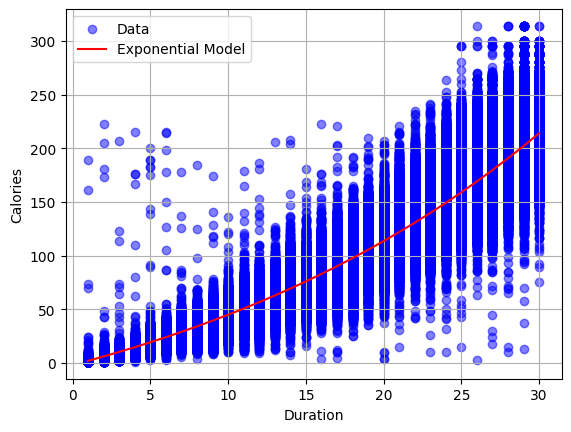

In [194]:
from scipy.optimize import curve_fit
# Exponential Model on 1 feature: 
X = data['Duration']
Y = data['Calories']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
def exp_func(x, a, b, c):
    return a * np.exp(b * x) + c

# Initial guesses (to make curve_fit converge faster)
initial_guess = [1, 0.1, 0]

# Adjusting the parameters
params, cov = curve_fit(exp_func, X_train, y_train, p0=initial_guess, maxfev=10000)
a, b, c = params

print(f"The exponential model was build : y = {a:.2f} * exp({b:.4f} * x) + {c:.2f}")

y_pred = exp_func(X_test, a, b, c)

order = np.argsort(X_test.values)
plt.scatter(X_train, y_train, color='blue', label='Data', alpha=0.5)
plt.plot(X_test.values[order], y_pred.iloc[order], color='red', label='Exponential Model')
plt.xlabel('Duration')
plt.ylabel('Calories')
plt.legend()
plt.grid()
plt.show()


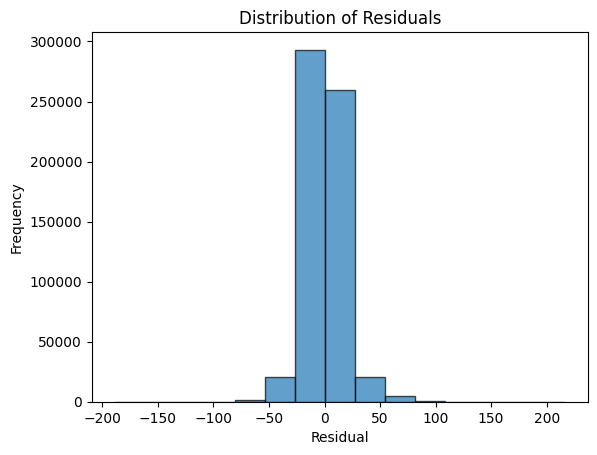

In [195]:

y_pred = exp_func(X_train, a, b, c)
residuals = y_train - y_pred
'''
plt.scatter(y_pred, residuals, alpha=0.5)
#plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Predicted vs Residuals")
plt.grid(True)
plt.show()
'''
plt.hist(residuals, bins=15, edgecolor='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()